In [62]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import os
import time
import seaborn as sb
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
stop_words = set(stopwords.words('english'))

In [4]:
dictionary = []

In [5]:
embeddings = {}

In [6]:
df = pd.read_csv("data/dataset/train-balanced-sarcasm.csv")

In [7]:
df_new = df[['parent_comment','comment','label']]

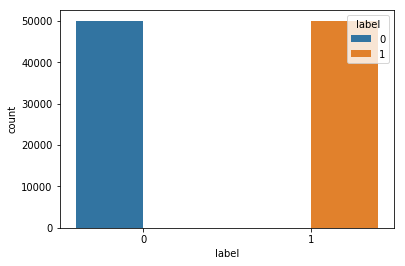

In [63]:
sb.countplot(x='label',hue='label',data=df_new)

In [8]:
df_new = df_new.sample(100000)

In [10]:
df_new.shape

(100000, 3)

In [11]:
df_new.head()

,parent_comment,comment,label
782258,Dear Libertarians I wish that you were all dea...,"Cool story, bro.",0
617258,I am a person who is unhappy with Starbound. I...,That and outside of the main quest there is ab...,0
646561,"So I calculated that on a website im 5' 11"" an...",Not a lot more but a small surplus of a few hu...,0
157433,Socialists who argue that one need only look a...,"No, no, no, we just didn't try hard enough!",1
298149,"It's written in stone. Don't blame ""people lik...","Yeah, well, we are working on carving a new me...",0


In [12]:
def remove_stopwords(tokens):
    tokens_wo_stopwords = []
    for i in range(0,len(tokens)):
        if tokens[i].lower() not in stop_words:
            tokens_wo_stopwords.append(tokens[i].lower())
    return tokens_wo_stopwords

In [13]:
def get_pos_tag(token):
    pos_tag = nltk.pos_tag([token])[0][1]
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    for i in range(0,len(tokens)):
        tokens[i] = lemmatizer.lemmatize(tokens[i],pos=str(get_pos_tag(tokens[i])))
    return tokens

In [15]:
def add_to_dictionary(tokens):
    for token in tokens:
        if token not in dictionary:
            dictionary.append(token)

In [16]:
def save_dictionary():
    with open('data/processed/dictionary.txt','w') as file:
        file.writelines("%s\n" % word for word in dictionary)

In [17]:
def read_dictionary():
    with open('data/processed/dictionary.txt','r') as file:
        temp = file.read().splitlines()
        for i in range(0,len(temp)):
            dictionary.append(temp[i])

In [18]:
def preprocess(sentence):
    processed_sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    tokens_comment = word_tokenize(processed_sentence)
    tokens_comment = remove_stopwords(tokens_comment)
    tokens_comment = lemmatize(tokens_comment)
    return tokens_comment

In [19]:
def create_dictionary(dataset):
    for index,row in dataset.iterrows():
        tokens_comment = preprocess(str(row['parent_comment']) + " " + str(row['comment']))
        add_to_dictionary(tokens_comment)
    save_dictionary()

In [20]:
def populate_embeddings_dict():
    starttime = time.time()
    with open('data/processed/glove.6B.300d.txt','r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            word_embedding = np.asarray(values[1:])
            embeddings[word] = word_embedding
    endtime = time.time()
    print("Time taken to load embeddings:- ")
    print(endtime - starttime)

In [21]:
def embedding_lookup(x,embedding_dim=300):
    if(len(embeddings) == 0):
        populate_embeddings_dict()
    embedding = []
    for i in range(0,len(x)):
        if(x[i] in embeddings):
            embedding.append(embeddings[x[i]])
        else:
            zero_arr = np.zeros(embedding_dim).tolist()
            embedding.append(zero_arr)
    embedding = np.array(embedding)
    return embedding

In [22]:
if not os.path.isfile('data/processed/dictionary.txt'):
    starttime = time.time()
    create_dictionary(df_new)
    endtime = time.time()
    print("Time to create dictionary")
    print(endtime - starttime)
else:   
    read_dictionary()

In [23]:
len(dictionary)

67028

In [24]:
embeddings = embedding_lookup(preprocess(df_new['comment'].iloc[0]))

Time taken to load embeddings:- 
35.096932888031006


In [26]:
preprocess(df_new['comment'].iloc[0])

['cool', 'story', 'bro']

In [33]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2",trainable=True)

In [54]:
def get_elmo_embeddings(tokens_input,tokens_length):
    embeddings = elmo(inputs={"tokens": tokens_input,"sequence_len": tokens_length},signature='tokens',as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)

In [55]:
tokens = preprocess(df_new['comment'].iloc[0])
tokens_input = [tokens]
tokens_length = [len(tokens)]
elmo_embeddings = get_elmo_embeddings(tokens_input,tokens_length)

In [56]:
elmo_embeddings.shape

(1, 3, 1024)

In [60]:
print("ELMO embeddings for 'cool'")
elmo_embeddings[0][0]

ELMO embeddings for 'cool'


array([ 0.08699809, -0.67682254,  0.91641057, ..., -0.30401048,
        0.30957115,  0.37923324], dtype=float32)

In [61]:
elmo_embeddings = {}

In [ ]:
def generate_elmo_embedding():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        for index,rows in df_new.iterrows():
            preprocessed_tokens = preprocess(rows['parent_comment'] + " " + rows['comment'])
            embedding_tensor = elmo(preprocessed_tokens)
            embeddings = sess.run(embedding_tensor)
            #Rest of the network here

In [ ]:
class LSTM():
    
    def __init__(self,num_classes,elmo_emmed_size,embed_size):
        self.X = tf.placeholder(shape=[None,None,embed_size + elmo_embed_size])
        self.y = tf.placeholder(shape=[None])
        self.sequence_lengths = tf.placeholder(shape=[None])
        self.num_classes = num_classes
        self.elmo_embed_size = elmo_embed_size
        self.embed_size = embed_size
        self.hidden_size = elmo_embed_size + embed_size
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(X,y,test_size=0.2,random_state=222)
    
    def model(self):
        cell_fw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_as_tuple=True,reuse=tf.get_variable_scope().reuse)
        cell_bw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_as_tuple=True,reuse=tf.get_variable_scope().reuse)
        with tf.variable_scope('Bi-Directional-LSTM'):
            (output_fw,output_bw), (output_state_fw, output_state_bw) = tf.nn.bidirectional_dynamic_lstm(
            cell_fw = cell_fw,
            cell_bw = cell_bw,
            inputs = self.X,
            sequence_lengths = self.sequence_lengths,
            dtype = tf.float32)
        self.final_state = tf.concat([output_state_fw,output_state_bx],axis=1)
        with tf.variable_scope('Softmax'):
            self.softmax_w = tf.get_variable('softmax_w',shape=[2 * self.hidden_size,self.num_classes],initializer=tf.truncated_normal_initializer(),dtype=tf.float32)
            self.softmax_b = tf.get_variable('softmax_b',shape=[self.num_classes],initializer=tf.constant_initializer(0.0),dtype=tf.float32)
        self.logits = tf.matmul(self.final_state,self.softmax_w) + self.softmax_b
        self.predictions = tf.argmax(tf.nn.softmax(self.logits),1,name='predictions')
        self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.y,self.logits))
        self.accuracy = tf.reduce_mean(tf.cast(,tf.float32),name='accuracy')